In [1]:
import sys
import time
import numpy as np
import numba as nb
from matplotlib import rc
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
PathWindows = r"D:\Учеба\Практика\Диплом\gamma"
LibraryPathWindows = r"D:\Учеба\Практика\Диплом\gamma\SpectrumsMeasurementsLibrary"
LibraryPathLinux = r"/home/danis/work/python_works/gamma"
sys.path.insert(0, LibraryPathWindows)
sys.path.insert(0, PathWindows)
sys.path.insert(0, LibraryPathLinux)

In [4]:
from GammaRayInteractions.Materials import Material, R
from CrossSectionsLibrary.cross_sections_data import ENERGY_MESH
from MeasurementInstrumentation.measurement_techniques import ideal_transmission_function, \
k_edge_method_transmission_function, ross_method_transmission_function, edges_indices, open_detector
from NumericalMethods.simpson_rule import simpson_rule
from NumericalMethods.unfolding_technique import Gold

import matplotlib.ticker as mticker
from local_scripts import initialization_brem, generate_empty_matrix, complete_empty_matrix, integrate_the_row, get_integral_signals, apply_function_to_matrix

In [9]:
font_properties = {'family' : 'Arial', 'weight' : 'regular', 'size' : 16}
rc('font', **font_properties)

Инициализация энергетического спектра

In [10]:
beam_energy = 0.075
z_number = 50

In [11]:
brem = initialization_brem(z_number, beam_energy)

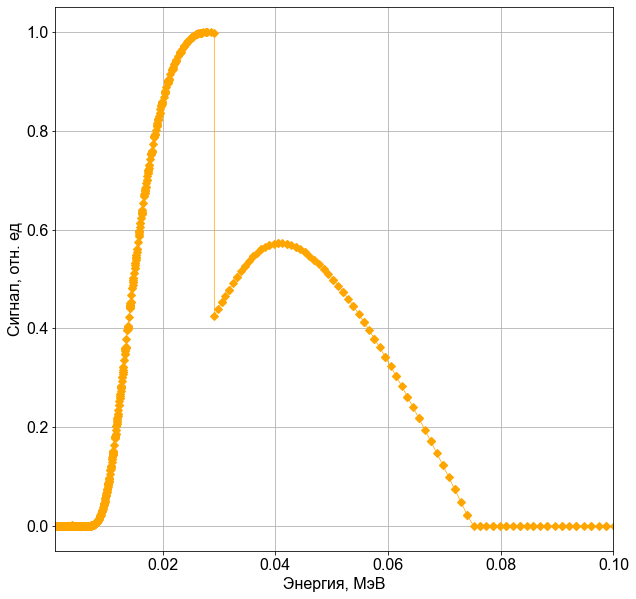

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(ENERGY_MESH, brem, ls='-', marker='D', lw='0.7', ms=5, color='orange')

# настройки графика
ax.set_xlabel('Энергия, МэВ')
ax.set_ylabel('Сигнал, отн. ед')
ax.tick_params(axis='both')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(1e-3, 1e-1)
# ax.set_ylim(1e-15, 1.2)
ax.grid(True)

Инициализация измерительных каналов

In [15]:
first_channel = 11
last_channel = 100 
number_of_channels = last_channel - first_channel + 1

In [126]:
level_1 = 0.3
level_2 = 0.3

In [127]:
# создание измерительных каналов системы 1
SYSTEM_1 = np.array([k_edge_method_transmission_function(num, level_1) for num in range(first_channel, last_channel+1)])
# создание измерительных каналов системы 2
SYSTEM_2 = np.array([k_edge_method_transmission_function(num, level_2) for num in range(first_channel, last_channel+1)])
SYSTEM_3 = np.vstack((SYSTEM_1, SYSTEM_2))

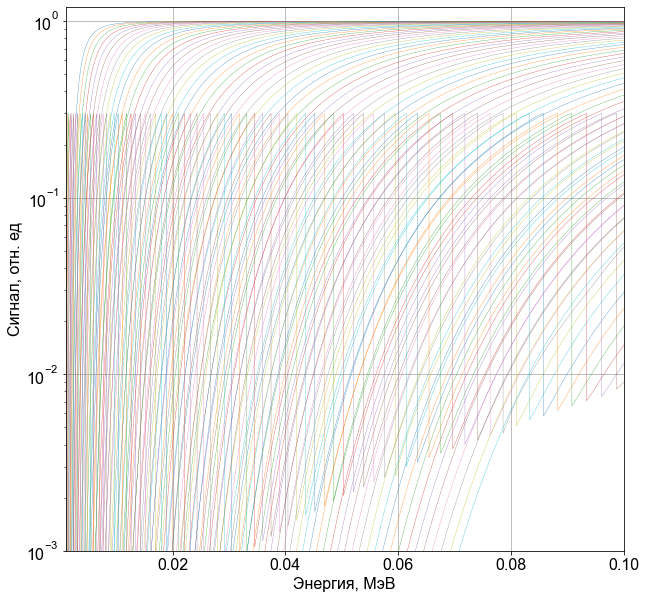

In [112]:
number_of_signals = fig, ax = plt.subplots(figsize=(10, 10))
for i in SYSTEM_1:
    ax.plot(ENERGY_MESH, i, ls='-', lw='0.3', ms=5)

# настройки графика
ax.set_xlabel('Энергия, МэВ')
ax.set_ylabel('Сигнал, отн. ед')
ax.tick_params(axis='both')
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-3, 1e-1)
ax.set_ylim(1e-3, 1.2)
ax.grid(True)

Создание матрицы с измерительной системы

In [113]:
# создание матрицы задачи
matrix1 = np.array([simpson_rule(r, regime='c', function_jumps=[Material(50).k_edge_index()]) for r in SYSTEM_1])
matrix2 = np.array([simpson_rule(r, regime='c', function_jumps=[Material(50).k_edge_index()]) for r in SYSTEM_2])
matrix3 = np.array([simpson_rule(r, regime='c', function_jumps=[Material(50).k_edge_index()]) for r in SYSTEM_3])

In [114]:
new_mesh1 = np.array(simpson_rule(SYSTEM_1[0], regime='m', function_jumps=[Material(50).k_edge_index()]))
new_mesh2 = np.array(simpson_rule(SYSTEM_2[0], regime='m', function_jumps=[Material(50).k_edge_index()]))
new_mesh3 = np.array(simpson_rule(SYSTEM_3[0], regime='m', function_jumps=[Material(50).k_edge_index()]))

Измерение энергетического спектра

In [137]:
signals1 = np.array([simpson_rule(r*brem) for r in SYSTEM_1])
signals2 = np.array([simpson_rule(r*brem) for r in SYSTEM_2])
signals3 = np.array([simpson_rule(r*brem) for r in SYSTEM_3])

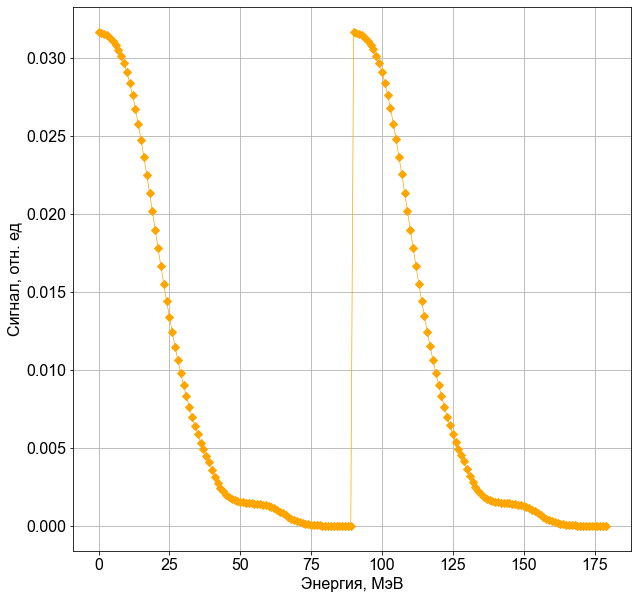

In [116]:
number_of_signals = len(SYSTEM_3)
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(range(len(signals)), signals3, ls='-', marker='D', lw='0.7', ms=5, color='orange')

# настройки графика
ax.set_xlabel('Энергия, МэВ')
ax.set_ylabel('Сигнал, отн. ед')
ax.tick_params(axis='both')
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(1e-3, 1e+2)
# ax.set_ylim(1e-15, 1.2)
ax.grid(True)

Восстановление спектра

In [120]:
bound_100_kev = Material(100).k_edge_index()

In [184]:
result = Gold(matrix1, signals1, -1, ENERGY_MESH, new_mesh1, brem, iteration_number=10000, bound=bound_100_kev, journal=False, weight_mode='value')

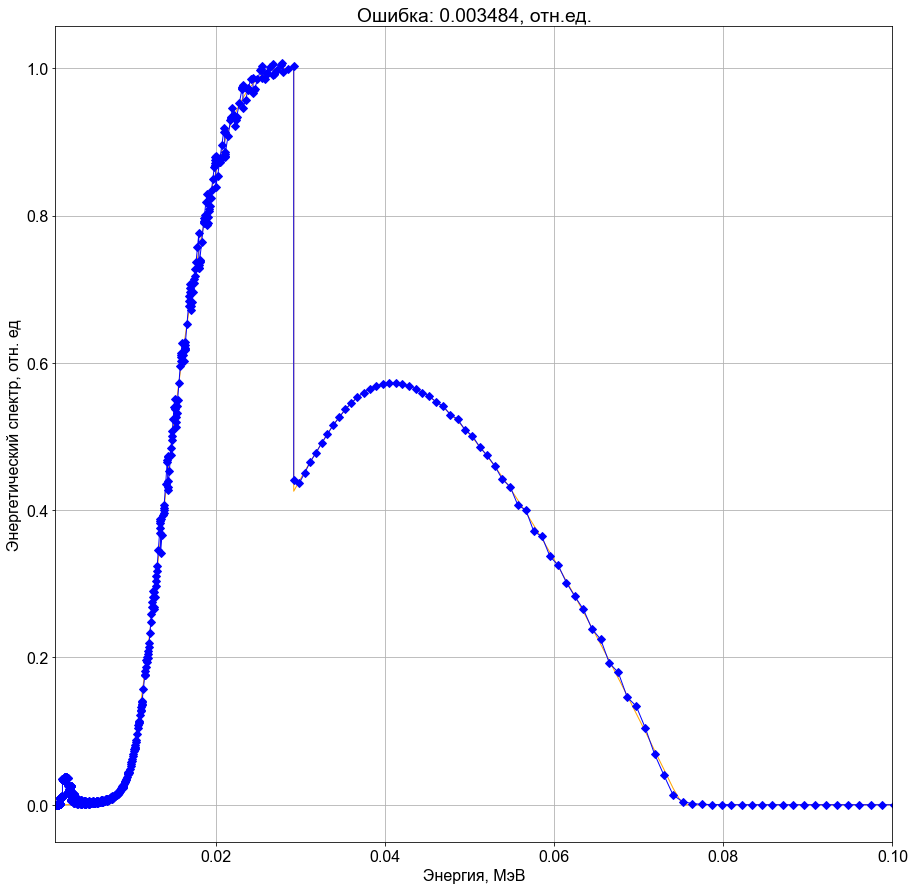

In [185]:
fig, ax = plt.subplots(figsize=(15, 15))

ax.plot(ENERGY_MESH, brem, ls='-', lw='1', ms=5, color='orange')
ax.plot(new_mesh, result[0], ls='-', lw='1', marker='D', ms=5, color='blue')


# настройки графика
ax.set_xlabel('Энергия, МэВ')
ax.set_ylabel('Энергетический спектр, отн. ед')
ax.tick_params(axis='both')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(1e-3, 0.1e0)
# ax.set_ylim(1e-7, 1.2)

ax.set_title(f'Ошибка: {round(result[1], 6)}, отн.ед.')

ax.grid(True)

In [186]:
result[1]

0.003483642837211259

Зависимость точности восстановления от обусловленности системы

In [158]:
max_level = 0.3

In [159]:
levels = np.linspace(0.3, 0.01, 30)

In [160]:
new_mesh1 = np.array(simpson_rule(SYSTEM_1[0], regime='m', function_jumps=[Material(50).k_edge_index()]))
new_mesh2 = np.array(simpson_rule(SYSTEM_2[0], regime='m', function_jumps=[Material(50).k_edge_index()]))
new_mesh3 = np.array(simpson_rule(SYSTEM_3[0], regime='m', function_jumps=[Material(50).k_edge_index()]))

In [161]:
# CONDS_M2 = np.empty((len(levels)), dtype=object)
# CONDS_M3 = np.empty((len(levels)), dtype=object)

# SIGNALS_M2 = np.empty((len(levels)), dtype=object)
# SIGNALS_M3 = np.empty((len(levels)), dtype=object)

# DEVIATIONS = np.empty((len(levels)), dtype=object)

# UNFOLDED_SPECTRUMS2 = np.empty((len(levels)), dtype=object)
# UNFOLDED_SPECTRUMS3 = np.empty((len(levels)), dtype=object)

In [164]:
# for i, level in enumerate(levels):
#     # создание измерительных каналов системы 1
#     system1 = np.array([k_edge_method_transmission_function(num, max_level) for num in range(first_channel, last_channel+1)])
#     # создание измерительных каналов системы 2
#     system2 = np.array([k_edge_method_transmission_function(num, level) for num in range(first_channel, last_channel+1)])
#     system3 = np.vstack((system1, system2))
    
#     # создание матрицы задачи
#     matrix1 = np.array([simpson_rule(r, regime='c', function_jumps=[Material(50).k_edge_index()]) for r in system1])
#     matrix2 = np.array([simpson_rule(r, regime='c', function_jumps=[Material(50).k_edge_index()]) for r in system2])
#     matrix3 = np.array([simpson_rule(r, regime='c', function_jumps=[Material(50).k_edge_index()]) for r in system3])
    
#     signals2 = np.array([simpson_rule(r*brem) for r in system2])
#     signals3 = np.array([simpson_rule(r*brem) for r in system3])
    
#     result1 = Gold(matrix1, signals1, -1, ENERGY_MESH, new_mesh1, brem, iteration_number=10000, bound=bound_100_kev, journal=False, weight_mode='value')
#     result2 = Gold(matrix2, signals2, -1, ENERGY_MESH, new_mesh2, brem, iteration_number=10000, bound=bound_100_kev, journal=False, weight_mode='value')
#     result3 = Gold(matrix3, signals3, -1, ENERGY_MESH, new_mesh3, brem, iteration_number=10000, bound=bound_100_kev, journal=False, weight_mode='value')
    
#     CONDS_M2[i] = np.linalg.cond(matrix2)
#     CONDS_M3[i] = np.linalg.cond(matrix3)
    
#     SIGNALS_M2[i] = signals2
#     SIGNALS_M3[i] = signals3
    
#     UNFOLDED_SPECTRUMS2 = result2[0]
#     UNFOLDED_SPECTRUMS3 = result3[0]
    
#     DEVIATIONS[i] = result3[1]
    
#     print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [171]:
SIGNALS_M1 = np.array([simpson_rule(r*brem) for r in system1])

In [182]:
SIGNALS_NORM = [np.linalg.norm(SIGNALS_M2[i]-SIGNALS_M1) for i in range(len(levels))]

Сохранение эксель файлов

In [183]:
from xlsxwriter.workbook import Workbook

workbook = Workbook("спектр6.xlsx")
worksheet = workbook.add_worksheet('Лист1')

# worksheet.write_column(5, 2, levels)
# worksheet.write_column(5, 4, CONDS_M2)
# worksheet.write_column(5, 5, CONDS_M3)
# worksheet.write_column(5, 7, DEVIATIONS)
worksheet.write_column(5, 7, SIGNALS_NORM)

workbook.close()

Сохранение результатов

In [160]:
# K_EDGE_METHOD_SIGNALS = np.save('СИГНАЛЫ_К_пропускание_08.npy', SIGNALS)